In [2]:
from imutils import paths
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss
from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module, ModuleList, ReLU
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import CenterCrop, Normalize
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir1 = "/content/drive/MyDrive/UIUC/seep_detection/train_images_256"
temp_dir2 = "/content/drive/MyDrive/UIUC/seep_detection/train_masks_256"
dir2 = "/content/drive/MyDrive/UIUC/seep_detection/binary_masks"
BASE_OUTPUT = "/content/drive/MyDrive/UIUC/seep_detection/output"

# Creating binary masked images and saving in a new directory


In [ ]:
for file in os.listdir(temp_dir2):
  mask_path = temp_dir2 + "/" + file
  mask_image = Image.open(mask_path)
  new_image = Image.new("I;16", mask_image.size)
  for x in range(mask_image.width):
    for y in range(mask_image.height):
        if mask_image.getpixel((x, y)) >= 1:
            new_image.putpixel((x, y), 65535)
        else:
            new_image.putpixel((x, y), mask_image.getpixel((x, y)))

  # Save the new image
  new_image.save(dir2 + "/"+ file)

Changed pixel values of given masked images from non-zero to white (65535 or 255)

Grayscale images in the TIFF format can have pixel values ranging from 0 to 65535, with 0 representing black and 65535 representing white. This is because TIFF files use a 16-bit unsigned integer data type to store the pixel values, which allows for a total of 2^16 (or 65,536) possible values. 

# Code

Config variables

In [5]:
DATASET_PATH = dir1

IMAGE_DATASET_PATH = dir1
MASK_DATASET_PATH = dir2


TEST_SPLIT = 0.15

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

INIT_LR = 0.001
NUM_EPOCHS = 1
BATCH_SIZE = 64

INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256

THRESHOLD = 0.5
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_seeps.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [10]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		return len(self.imagePaths)

	def __getitem__(self, idx):
		imagePath = self.imagePaths[idx]
		mask_path = self.maskPaths[idx]

		image = Image.open(imagePath)
		mask = Image.open(mask_path)
		
		image = torch.from_numpy(np.float32(np.array(image)))
		mask = torch.from_numpy(np.float32(np.array(mask)))

		image = F.normalize(image, p=2, dim=None)
		mask = F.normalize(image, p=2, dim=None)

		return (image, mask)

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv6 = nn.Conv2d(1536, 512, 3, padding=1)
        self.conv7 = nn.Conv2d(768, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(384, 128, 3, padding=1)
        self.conv9 = nn.Conv2d(192, 64, 3, padding=1)
        self.conv10 = nn.Conv2d(64, 1, 1)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(
            scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = self.max_pool(x1)
        x2 = F.relu(self.conv2(x2))
        x3 = self.max_pool(x2)
        x3 = F.relu(self.conv3(x3))
        x4 = self.max_pool(x3)
        x4 = F.relu(self.conv4(x4))
        x5 = self.max_pool(x4)
        x5 = F.relu(self.conv5(x5))
        x6 = self.upsample(x5)
        x6 = F.relu(self.conv6(torch.cat([x6, x4], dim=1)))
        x7 = self.upsample(x6)
        x7 = F.relu(self.conv7(torch.cat([x7, x3], dim=1)))
        x8 = self.upsample(x7)
        x8 = F.relu(self.conv8(torch.cat([x8, x2], dim=1)))
        x9 = self.upsample(x8)
        x9 = F.relu(self.conv9(torch.cat([x9, x1], dim=1)))
        x10 = self.conv10(x9)
        return x10

In [12]:
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))

split = train_test_split(imagePaths, maskPaths,
                         test_size=TEST_SPLIT, random_state=42)

(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [13]:
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

trainLoader = DataLoader(trainDS, 
                         batch_size=BATCH_SIZE,
						 pin_memory=PIN_MEMORY,
						 num_workers=os.cpu_count())
testLoader = DataLoader(testDS, 
                        batch_size=BATCH_SIZE,
						pin_memory=PIN_MEMORY, 
						num_workers=os.cpu_count())

[INFO] found 671 examples in the training set...
[INFO] found 119 examples in the test set...


In [14]:
unet = UNet().to(DEVICE)

lossFunc = BCEWithLogitsLoss()

opt = Adam(unet.parameters(), lr=INIT_LR)

trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

H = {"train_loss": [], "test_loss": [], "batch_loss": []}

In [15]:
PATH = "/content/drive/MyDrive/UIUC/seep_detection/model.pth"

In [16]:
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    unet.train()
    totalTrainLoss = 0
    totalTestLoss = 0

    for (i, (x, y)) in enumerate(trainLoader):
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        opt.zero_grad()
        with torch.set_grad_enabled(True):
            x = x.unsqueeze(1)
            output = unet(x)

            pred = torch.argmax(output, dim=1)
            y = y.unsqueeze(1)
            loss = lossFunc(output.float(), y)
            loss.backward()
            opt.step()
            torch.save(unet.state_dict(), PATH)
        H['batch_loss'].append(loss.detach().item())
        totalTrainLoss += loss.detach()

    with torch.no_grad():
        unet.eval()
  
        for (x, y) in testLoader:
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            x = x.unsqueeze(1)
            output = unet(x)
            pred = torch.argmax(output, dim=1)
            y = y.unsqueeze(1)
            loss = lossFunc(output.float(), y)
            totalTestLoss += loss.detach()
   
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps

    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

[INFO] training the network...


  0%|          | 0/1 [19:08<?, ?it/s]


KeyboardInterrupt: ignored

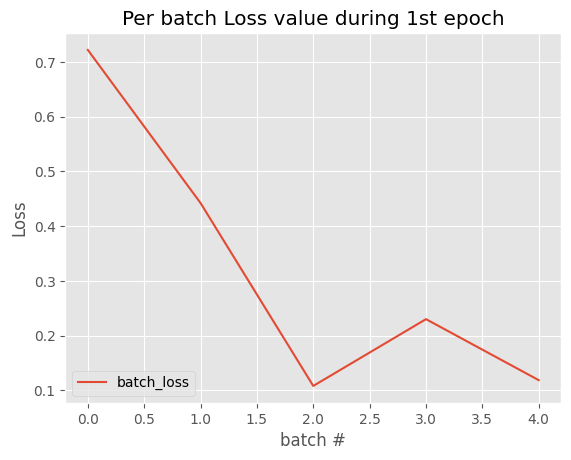

In [18]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H['batch_loss'], label="batch_loss")
plt.title("Per batch Loss value during 1st epoch")
plt.xlabel("batch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
#torch.save(unet, MODEL_PATH)

## Predictions from the model

In [19]:
unet = UNet()
unet.load_state_dict(torch.load(PATH))
unet.eval()

UNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(1536, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(768, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
)

In [20]:
def prepare_plot(origImage, origMask, predMask):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

	# plot the original image, its mask, and the predicted mask   
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)

	# set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")

	# set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [21]:
def make_predictions(model, imagePath):
    model.eval()

    with torch.no_grad():
        
        image = Image.open(imagePath)
        orig = image.copy()

        image = np.expand_dims(image, 0)
        image = torch.from_numpy(np.float32(np.array(image))).to(DEVICE)
        image = F.normalize(image, p=2, dim=None)
        image = image.unsqueeze(1)

    # make the prediction, pass the results through the sigmoid
    # function, and convert the result to a NumPy array
    predMask = model(image)
    predMask = torch.sigmoid(predMask)
    predMask = predMask.detach().numpy()

    # find the filename and generate the path to ground truth mask
    filename = imagePath.split(os.path.sep)[-1]
    groundTruthPath = os.path.join(MASK_DATASET_PATH, filename)

    # load the ground-truth segmentation mask in grayscale mode and resize it
    gtMask = Image.open(groundTruthPath)

    # filter out the weak predictions and convert them to integers
    predMask = (predMask > THRESHOLD) * 65535
    predMask = predMask.astype(np.uint8)
    predMask_final = predMask[0, 0, :, :]
    pred_pil = Image.fromarray(predMask_final)

    # prepare a plot for visualization
    prepare_plot(orig, gtMask, pred_pil)


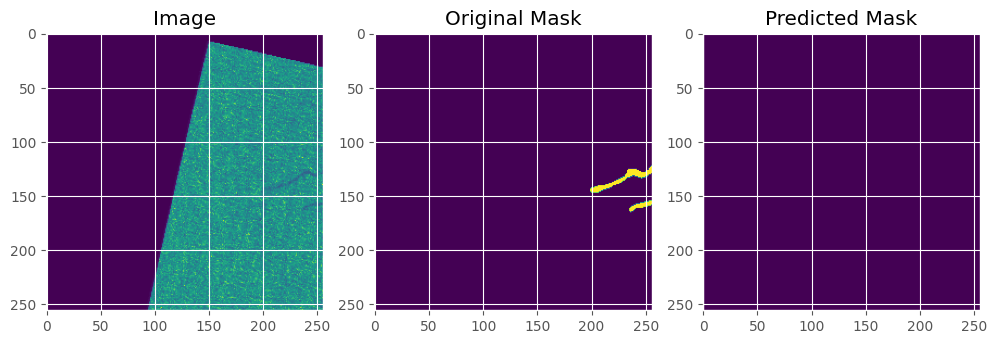

In [22]:
imagePath = "/content/drive/MyDrive/UIUC/seep_detection/train_images_256/041869.000003.tif"
make_predictions(unet, imagePath)

[INFO] loading up test image paths...
[INFO] load up model...


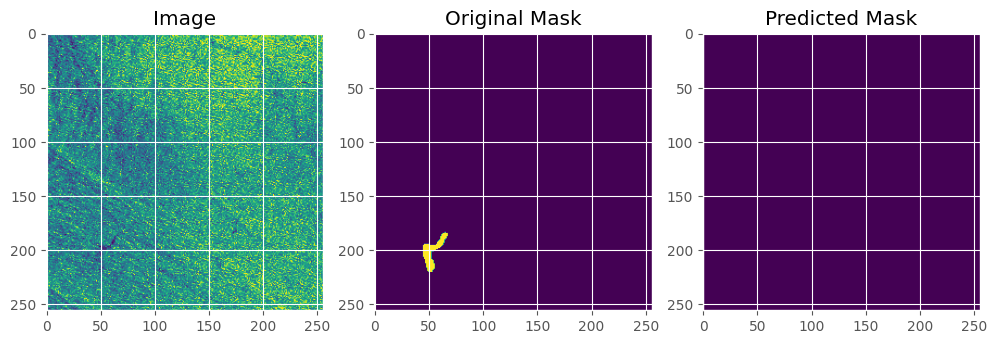

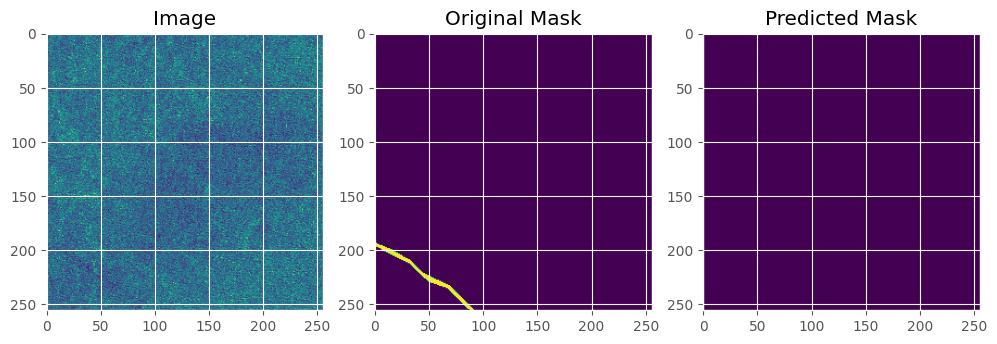

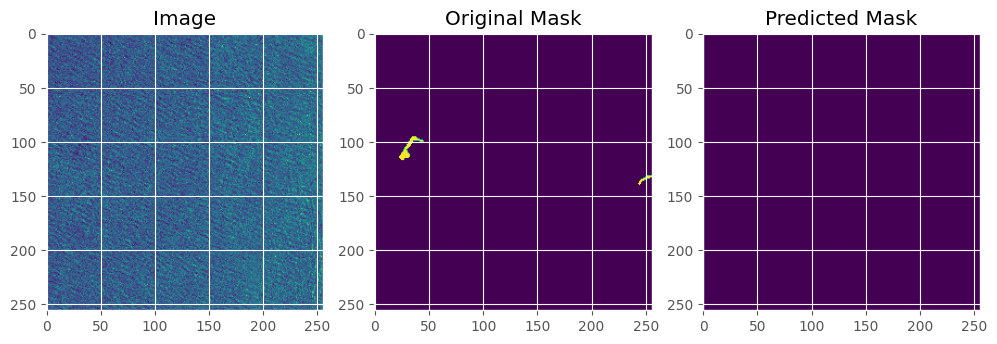

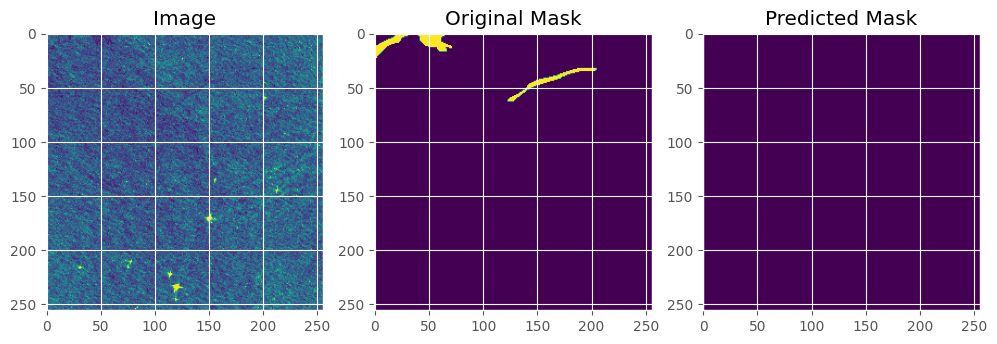

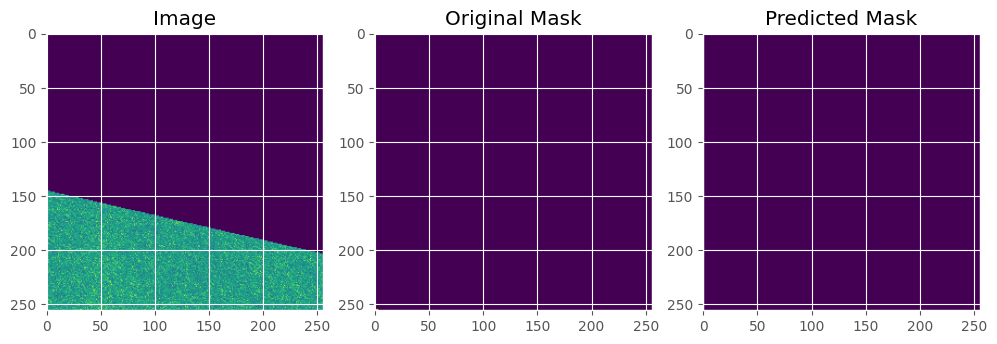

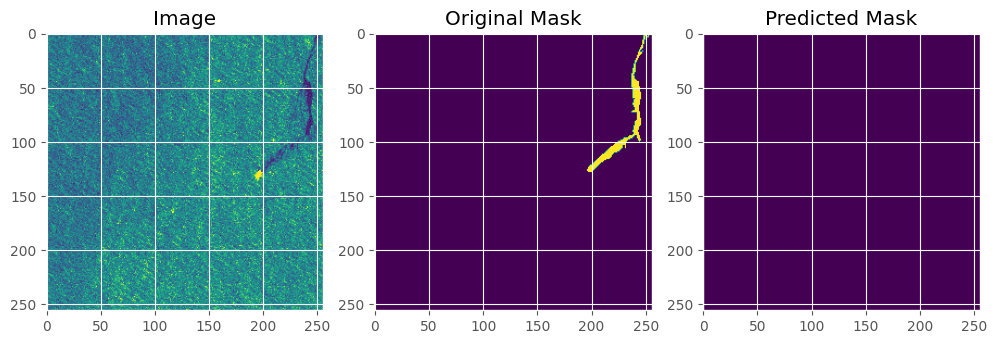

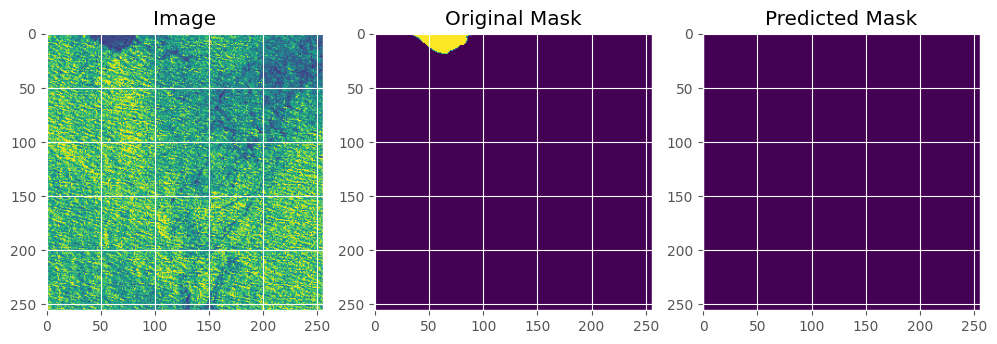

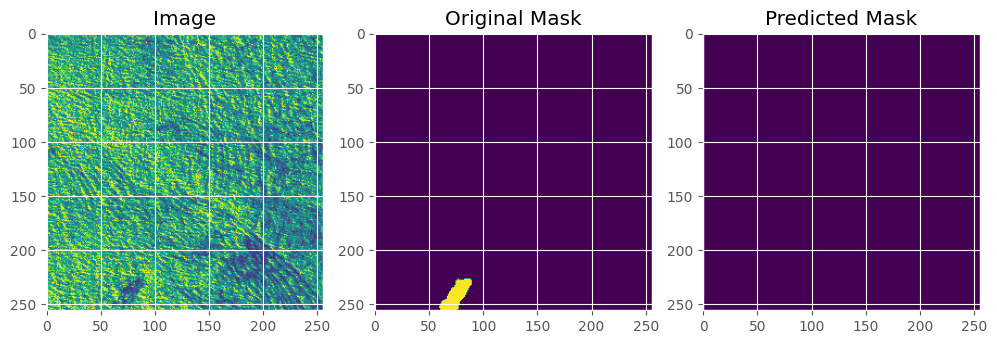

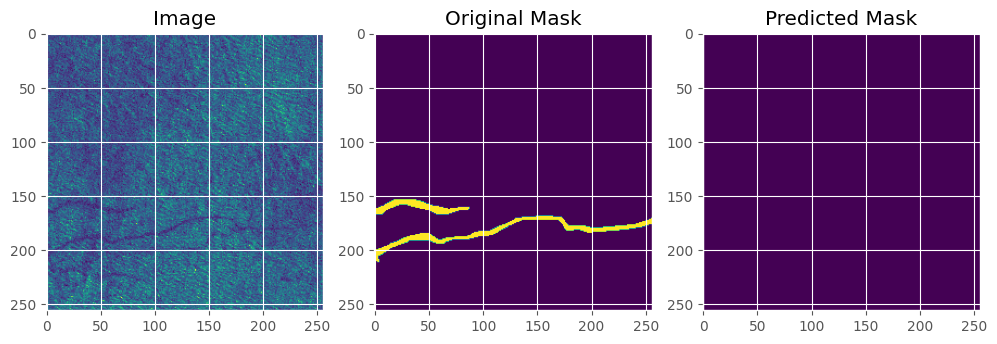

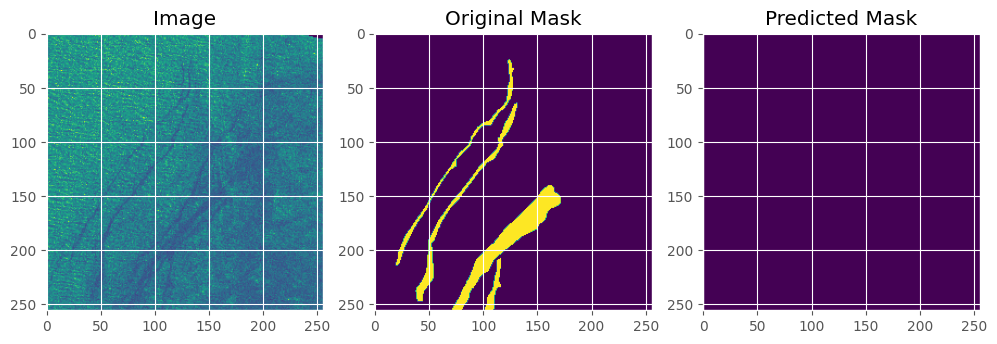

In [23]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

# load our model from disk
print("[INFO] load up model...")
unet = UNet()
unet.load_state_dict(torch.load(PATH))
#unet = torch.load(MODEL_PATH).to(DEVICE)

# iterate over the randomly selected test image paths
for path in imagePaths:
	make_predictions(unet, path)
